In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm

from sklearn.metrics import log_loss, accuracy_score, classification_report, plot_confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

## 几个可视化函数

对于keras模型，离散分类预测要使用`predict_classes`。

`plot_confusion_matrix`不能用于keras模型，需要自己实现。使用`seaborn.heatmap`可以简单实现一个兼容版本。

In [2]:
history = pd.DataFrame(
    [],
    columns=pd.MultiIndex.from_product([['train', 'validate'], ['logloss', 'accuracy']]),
    dtype='float32'
)

def plot_confusion_matrix_keras(model, x, y, display_labels=None, values_format='d', cmap='Blues'):
    classes = np.unique(y)
    if display_labels is None:
        display_labels = list(classes)
    d = []
    for cls in classes:
        predictions = model.predict_classes(x[y==cls])
        d.append([np.count_nonzero(predictions==subcls) for subcls in classes])
    d = np.asarray(d)
    sns.heatmap(
        d, cmap=cmap, fmt=values_format,
        annot=True, square=True, xticklabels=display_labels, yticklabels=display_labels
    )
    plt.xlabel('Predicted label')
    plt.ylabel('Truth label')

def evaluate_model(clf, slug, xtrain, ytrain, xvalid, yvalid, fit=True):
    global history
    if fit:
        clf.fit(xtrain, ytrain)

    # print loss values
    predictions = clf.predict_proba(xtrain)
    print ("train set: logloss: %0.3f" % (log_loss(ytrain, predictions), ))
    history.loc[slug, ('train', 'logloss')] = log_loss(ytrain, predictions)
    predictions = clf.predict_proba(xvalid)
    print ("valid set: logloss: %0.3f" % (log_loss(yvalid, predictions), ))
    history.loc[slug, ('validate', 'logloss')] = log_loss(yvalid, predictions)
    
    # print accuracy matrix
    predictions = clf.predict_classes(xtrain)
    print('train set')
    print(classification_report(ytrain, predictions, target_names=lbl_enc.classes_, digits=3))
    print('-' * 70)
    predictions = clf.predict_classes(xvalid)
    print('validate set')
    print(classification_report(yvalid, predictions, target_names=lbl_enc.classes_, digits=3))

    plot_confusion_matrix_keras(clf, xvalid, yvalid, display_labels=lbl_enc.classes_, values_format='d', cmap='Blues')
    plt.grid(False)
    
    history.loc[slug, ('train', 'accuracy')] = balanced_accuracy_score(ytrain, clf.predict_classes(xtrain))
    history.loc[slug, ('validate', 'accuracy')] = balanced_accuracy_score(yvalid, clf.predict_classes(xvalid))

In [3]:
def plot_keras_history(history):
    plt.figure(figsize=(14, 7))
    # Plot training & validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')

    plt.show()
    


## 载入数据及标签化处理

In [4]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [5]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

深度学习神经网络一般使用one-hot编码输出，因此多增加一个`to_categorical`的步骤。

In [6]:
# we need to binarize the labels for the neural net
ytrain_enc = utils.to_categorical(ytrain)
yvalid_enc = utils.to_categorical(yvalid)
pd.DataFrame({
    'author': np.asarray(lbl_enc.classes_)[ytrain],
    'label': ytrain,
    'encoded': ytrain_enc.tolist()
}).head()

,author,label,encoded
0,MWS,2,"[0.0, 0.0, 1.0]"
1,EAP,0,"[1.0, 0.0, 0.0]"
2,MWS,2,"[0.0, 0.0, 1.0]"
3,HPL,1,"[0.0, 1.0, 0.0]"
4,MWS,2,"[0.0, 0.0, 1.0]"


`keras.text.Tokenizer`实现了词袋、计数、词频和TF-IDF多种特征提取方式。一般可以直接使用，不必再使用`sklearn`的类似组件。[API](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)

In [7]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)

token.fit_on_texts(list(xtrain) + list(xvalid))

word_index = token.word_index

In [8]:
# mode: one of "binary", "count", "tfidf", "freq".
xtrain_enc = token.texts_to_matrix(xtrain, mode='count')
xvalid_enc = token.texts_to_matrix(xvalid, mode='count')


print('original text:\n  ', xtrain[0], '\n')
print('encoded features:\n  ', xtrain_enc[0], '\n')
print('nonzero position:\n  ', np.nonzero(xtrain_enc[0]), '\n')
print('nonzero values:\n  ', xtrain_enc[0][xtrain_enc[0] > 0], '\n')
print('nonzero words:\n  ', [token.index_word.get(idx, 'PAD') for idx, x in enumerate(xtrain_enc[0]) if x ], '\n')

original text:
   Her hair was the brightest living gold, and despite the poverty of her clothing, seemed to set a crown of distinction on her head. 

encoded features:
   [0. 2. 2. ... 0. 0. 0.] 

nonzero position:
   (array([   1,    2,    3,    4,    5,    8,   27,   29,   98,  166,  326,
        459,  560,  714,  987, 1794, 2545, 3103, 3695, 5924], dtype=int64),) 

nonzero values:
   [2. 2. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 

nonzero words:
   ['the', 'of', 'and', 'to', 'a', 'was', 'on', 'her', 'seemed', 'head', 'set', 'living', 'hair', 'gold', 'despite', 'poverty', 'crown', 'distinction', 'clothing', 'brightest'] 



## 模型搭建

In [9]:
len(xtrain_enc[0])

25944

In [10]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, activation='relu', input_dim=len(xtrain_enc[0])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(3))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', ])

## 训练

In [11]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(
    xtrain_enc, y=ytrain_enc, batch_size=512, epochs=100, 
    verbose=1, validation_data=(xvalid_enc, yvalid_enc), callbacks=[earlystop]
)

Epoch 1/100
35/35 [==============================] - 4s 81ms/step - loss: 1.0210 - categorical_accuracy: 0.5683 - val_loss: 0.9533 - val_categorical_accuracy: 0.5097
Epoch 2/100
35/35 [==============================] - 2s 64ms/step - loss: 0.2021 - categorical_accuracy: 0.9341 - val_loss: 0.8716 - val_categorical_accuracy: 0.6302
Epoch 3/100
35/35 [==============================] - 2s 51ms/step - loss: 0.0628 - categorical_accuracy: 0.9828 - val_loss: 0.8099 - val_categorical_accuracy: 0.6772
Epoch 4/100
35/35 [==============================] - 2s 45ms/step - loss: 0.0233 - categorical_accuracy: 0.9959 - val_loss: 0.7384 - val_categorical_accuracy: 0.7421
Epoch 5/100
35/35 [==============================] - 2s 45ms/step - loss: 0.0111 - categorical_accuracy: 0.9985 - val_loss: 0.6658 - val_categorical_accuracy: 0.7829
Epoch 6/100
35/35 [==============================] - 2s 49ms/step - loss: 0.0066 - categorical_accuracy: 0.9993 - val_loss: 0.5913 - val_categorical_accuracy: 0.8064
Epoc

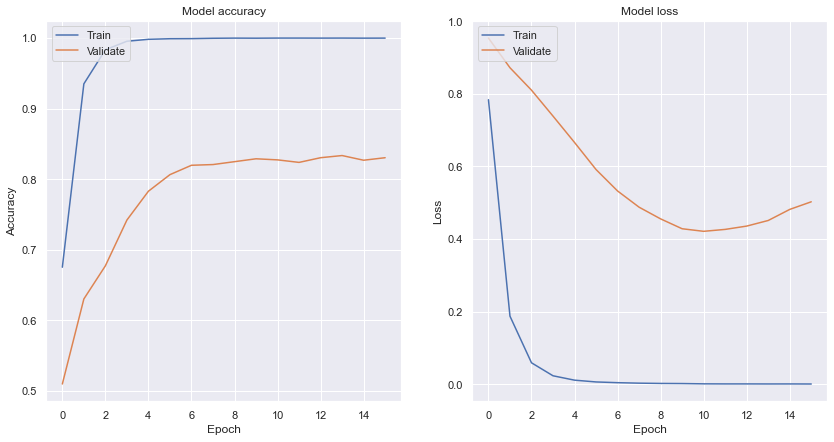

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               7783500   
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 9

In [12]:
plot_keras_history(model.history)
model.summary()

In [13]:
len(xtrain_enc[0]) * 300 + 300

7783500

In [14]:
300 * 300 + 300

90300

In [15]:
300 * 3 + 3

903

## 模型评估

## 增加GloVec Embedding

In [17]:
with open('./data/glove.compress.embeddings.pickle', 'rb') as f:
    embeddings_index = pickle.load(f)

with open('./data/glove.compress.vocabulary.pickle', 'rb') as f:
    vocabulary = pickle.load(f)

## 把GloVec查表转换为矩阵

可以继续使用前几章的查表方式，但是这里引入嵌入矩阵的方法，以便后面用于深度学习的嵌入层

In [18]:
# create an embedding matrix for the words we have in the dataset
embedding_width = len(embeddings_index['the'])
embedding_matrix = np.zeros((len(word_index) + 1, embedding_width))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print('shape of train matrix:', xtrain_enc.shape)
print('shape of embedding matrix:', embedding_matrix.shape)

  0%|          | 0/25943 [00:00<?, ?it/s]

shape of train matrix: (17621, 25944)
shape of embedding matrix: (25944, 300)


引入嵌入矩阵后，查表操作变成了查下标操作

In [19]:
print(word_index['should'])
print(embedding_matrix[word_index['should']])

96
[-0.013048    0.066305   -0.18674999 -0.077878   -0.16395    -0.25972
  0.029303   -0.15825    -0.19078     2.8283     -0.163      -0.05534
  0.22109     0.21402    -0.15347999 -0.066198    0.010375    1.1365
 -0.38681999  0.25817001 -0.096464   -0.084158    0.076939   -0.30340001
 -0.030256    0.13372    -0.17986    -0.30307001  0.052078   -0.28134999
 -0.45357001 -0.05815     0.13801999  0.12679    -0.15589    -0.096631
 -0.041036   -0.0067604  -0.20026    -0.1105     -0.16964     0.13875
 -0.077402   -0.061383   -0.097824   -0.14076    -0.20308    -0.18849
 -0.28672999  0.15407    -0.13096    -0.032663    0.090106   -0.12916
  0.34599999 -0.018437   -0.011253   -0.35414001 -0.053053   -0.088397
 -0.30039999 -0.16288     0.088432    0.54714     0.45056     0.23582
 -0.24749     0.25558999  0.34963    -0.060627    0.0033251  -0.004153
  0.46325999 -0.010819    0.24965    -0.065957    0.14683001 -0.30344
  0.16347     0.16621999 -0.14835    -0.07946    -0.54354     0.015714
 -0.0787

批量查询可以使用矩阵的点乘操作

In [20]:
x_train_embeddings = np.dot(xtrain_enc, embedding_matrix)
x_valid_embeddings = np.dot(xvalid_enc, embedding_matrix)
x_train_embeddings.shape

(17621, 300)

In [21]:
x = np.zeros_like(x_train_embeddings[0])
for idx, count in enumerate(xtrain_enc[0]):
    if count == 0: continue
    word = token.index_word[idx]
    if word not in embeddings_index: continue
    x += embeddings_index[word] * count
np.all(np.isclose(x, x_train_embeddings[0]))

True

## 网络搭建

搭建一个新的神经网络，加入`LayerNormalization`层，以便对输入向量做适当调整

In [22]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(LayerNormalization(input_shape=(300,)))

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(3))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', ])

In [23]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(
    x_train_embeddings, y=ytrain_enc, batch_size=512, epochs=100, 
    verbose=1, validation_data=(x_valid_embeddings, yvalid_enc), callbacks=[earlystop]
)

Epoch 1/100
35/35 [==============================] - 2s 17ms/step - loss: 1.1615 - categorical_accuracy: 0.5123 - val_loss: 0.8856 - val_categorical_accuracy: 0.6175
Epoch 2/100
35/35 [==============================] - 0s 8ms/step - loss: 0.8136 - categorical_accuracy: 0.6588 - val_loss: 0.8136 - val_categorical_accuracy: 0.6456
Epoch 3/100
35/35 [==============================] - 0s 8ms/step - loss: 0.7481 - categorical_accuracy: 0.6821 - val_loss: 0.7574 - val_categorical_accuracy: 0.6982
Epoch 4/100
35/35 [==============================] - 0s 8ms/step - loss: 0.6779 - categorical_accuracy: 0.7126 - val_loss: 0.7130 - val_categorical_accuracy: 0.7390
Epoch 5/100
35/35 [==============================] - 0s 8ms/step - loss: 0.6290 - categorical_accuracy: 0.7408 - val_loss: 0.6913 - val_categorical_accuracy: 0.7232
Epoch 6/100
35/35 [==============================] - 0s 8ms/step - loss: 0.6027 - categorical_accuracy: 0.7497 - val_loss: 0.6685 - val_categorical_accuracy: 0.7288
Epoch 7/1

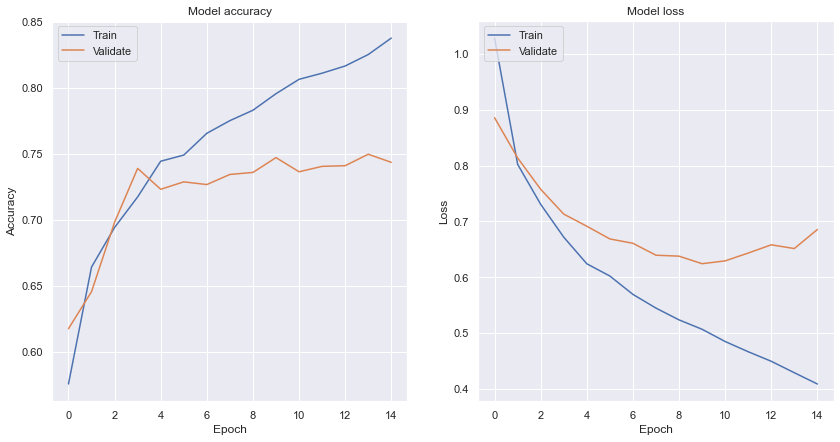

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization (LayerNo (None, 300)               600       
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 300)              

In [24]:
plot_keras_history(model.history)
model.summary()

## 模型评估

e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train set: logloss: 0.352
valid set: logloss: 0.685


e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


train set
              precision    recall  f1-score   support

         EAP      0.924     0.815     0.866      7110
         HPL      0.913     0.856     0.884      5071
         MWS      0.783     0.948     0.857      5440

    accuracy                          0.868     17621
   macro avg      0.873     0.873     0.869     17621
weighted avg      0.877     0.868     0.868     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.823     0.699     0.756       790
         HPL      0.765     0.711     0.737       564
         MWS      0.659     0.833     0.736       604

    accuracy                          0.744      1958
   macro avg      0.749     0.748     0.743      1958
weighted avg      0.756     0.744     0.744      1958



e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
e:\venvs\nlp\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` las

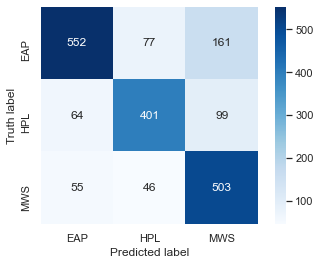

In [25]:
evaluate_model(model, 'FC Network+GloVec', x_train_embeddings, ytrain, x_valid_embeddings, yvalid, fit=None)

## 模型比较

使用GloVec后，模型准确率、复杂度和过拟合程度均有下降。实际使用的时候要做好权衡。

In [26]:
history

train            validate          
                    logloss  accuracy   logloss  accuracy
FC Network+BoW     0.001432  1.000000  0.502453  0.825905
FC Network+GloVec  0.352170  0.873126  0.685371  0.747503